### This document contains the transition functions for each of the examples that we use. 


For each example we will write the following functions:
- F from noise. 
- G from noise.
- f weight function
- g weight function.

And the Optimal Sample and Weight function where applicable.

In [65]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax

## Constants

In [66]:
TAU = 1 / (256 * 8 * 60)
KAPPA = 12
X_BAR = jnp.log(0.16)
SIGMA_SIGMA = 6.4
RHO = 0.8

# AR(1) Example

In [67]:
SIGMA_Y = 3.2

def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = last_val + TAU * KAPPA * (X_BAR - last_val)
    std = jnp.sqrt(TAU) * SIGMA_SIGMA
    next_val = noise * std + means
    return next_val


def ar1_g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """    
    return total_noise * jnp.sqrt(TAU) * SIGMA_Y + all_particles


In [68]:

def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = prev_particle + TAU * KAPPA * (X_BAR - prev_particle)  # Mean reversion
    f_std = jnp.sqrt(TAU) * SIGMA_SIGMA  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 


def ar1_g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), particle, jnp.sqrt(TAU) * SIGMA_Y)



Optimal Functions

In [69]:
def ar1_optimal_sample(subkey, particles, Y_array, idt):

    mean_reversion_term = particles + TAU * KAPPA * (X_BAR - particles)
    optimal_var = (1 / (TAU * SIGMA_SIGMA**2) + 1 / (TAU * SIGMA_Y**2))**(-1)

    optimal_mean_numerator = (mean_reversion_term / (TAU * SIGMA_SIGMA**2)) + (Y_array.at[idt].get() / (TAU * SIGMA_Y**2)) 
    optimal_mean = optimal_mean_numerator * optimal_var
    
    new_particles = jax.random.normal(subkey, len(particles)) * jnp.sqrt(optimal_var) + optimal_mean
    
    return new_particles


def ar1_optimal_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    mean_reversion_term = particle + TAU * KAPPA * (X_BAR - particle)
    optimal_var = (1 / (TAU * SIGMA_SIGMA**2) + 1 / (TAU * SIGMA_Y**2))**(-1)

    optimal_mean_numerator = (mean_reversion_term / (TAU * SIGMA_SIGMA**2)) + (Y_array.at[idt].get() / (TAU * SIGMA_Y**2)) 
    optimal_mean = optimal_mean_numerator * optimal_var
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), optimal_mean, jnp.sqrt(optimal_var))

ar1_optimal_likelihood_weight_fn = jax.vmap(ar1_optimal_likelihood_single, in_axes=(0, 0, None, None))


# Stochastic Volatility Example

In [70]:
# f from noise is same as before.

def g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """
    y_means = -0.5 * TAU * jnp.exp(2 * all_particles)
    y_stds = jnp.sqrt(TAU) * jnp.exp(all_particles)
    
    return total_noise * y_stds + y_means

In [71]:
# f likelihood is same as before

def g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    std = jnp.sqrt(TAU) * jnp.exp(prev_particle)  # full variance
    mean = -0.5 * std**2  # expected mean
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), mean, std)

g_likelihood_weight_fn = jax.vmap(g_likelihood_single, in_axes=(0, 0, None, None))


# Stochastic Volatility with Skew Example

In [72]:
# f from noise is same as before.

def skew_g_from_total_noise(prev_particle, particle, noise):
    # Mean reversion term: E[X_t | X_{t-1}] = X_{t-1} + κτ(X̄ - X_{t-1})
    mean_reversion_term = prev_particle + KAPPA * TAU * (X_BAR - prev_particle)

    # Mean: μ_Y = -0.5τ exp(2X_t) + ρ(exp(X_t)/σ²)(X_t - E[X_t | X_{t-1}])
    skew_total_mean = -0.5 * TAU * jnp.exp(2 * particle) + RHO * (jnp.exp(particle) / SIGMA_SIGMA) * (particle - mean_reversion_term)
    
    # Variance: σ²_Y = τ exp(2X_t)(1 - ρ²)
    skew_total_var = TAU * jnp.exp(2 * particle) * (1 - RHO**2)

    return skew_total_mean + noise * jnp.sqrt(skew_total_var)

In [73]:
# f likelihood is same as before.

def skew_observation_weight_single(particle, prev_particle, Y_array, idt):

    # Mean reversion term: E[X_t | X_{t-1}] = X_{t-1} + κτ(X̄ - X_{t-1})
    mean_reversion_term = prev_particle + KAPPA * TAU * (X_BAR - prev_particle)

    # Skew-normal distribution parameters for Y[t]
    # Mean: μ_Y = -0.5τ exp(2X_t) + ρ(exp(X_t)/σ²)(X_t - E[X_t | X_{t-1}])
    skew_total_mean = -0.5 * TAU * jnp.exp(2 * particle) + RHO  * (jnp.exp(particle) / SIGMA_SIGMA) * (particle - mean_reversion_term)
    
    # Variance: σ²_Y = τ exp(2X_t)(1 - ρ²)
    skew_total_var = TAU * jnp.exp(2 * particle) * (1 - RHO**2)

    # Return log-likelihood: log P(Y[idt] | X_t, X_{t-1})
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), skew_total_mean, jnp.sqrt(skew_total_var))



# Testing Function as we go. 


### Data Generation.

We load up the PFVehicle for each of the examples, we then generate data from the examples. Plotting as we go, we should be able to notice the diffenrence

In [74]:
from nnp_functions.pf_vehicle import PFVehicle

ar1_pf_vehicle = PFVehicle(f_from_noise, ar1_g_from_total_noise, f_likelihood_single, ar1_g_likelihood_single)
stoch_pf_vehicle = PFVehicle(f_from_noise, g_from_total_noise, f_likelihood_single, g_likelihood_single)
skew_pf_vehicle = PFVehicle(f_from_noise, skew_g_from_total_noise, f_likelihood_single, skew_observation_weight_single)


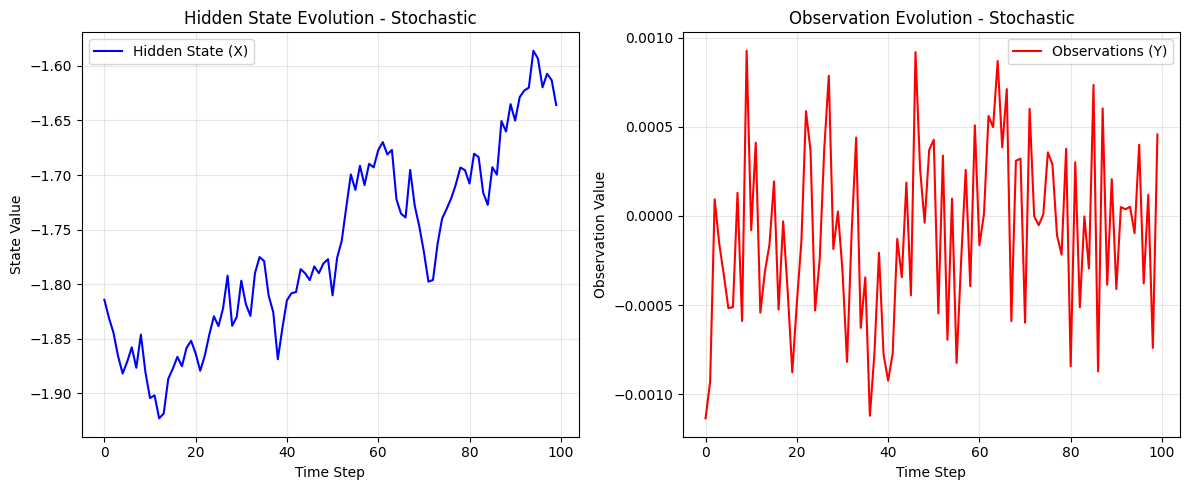

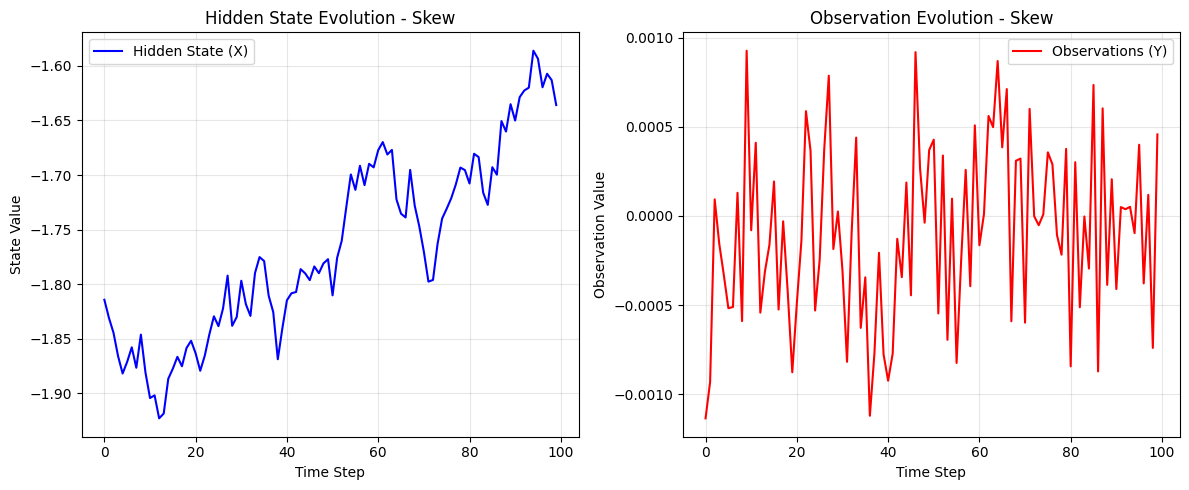

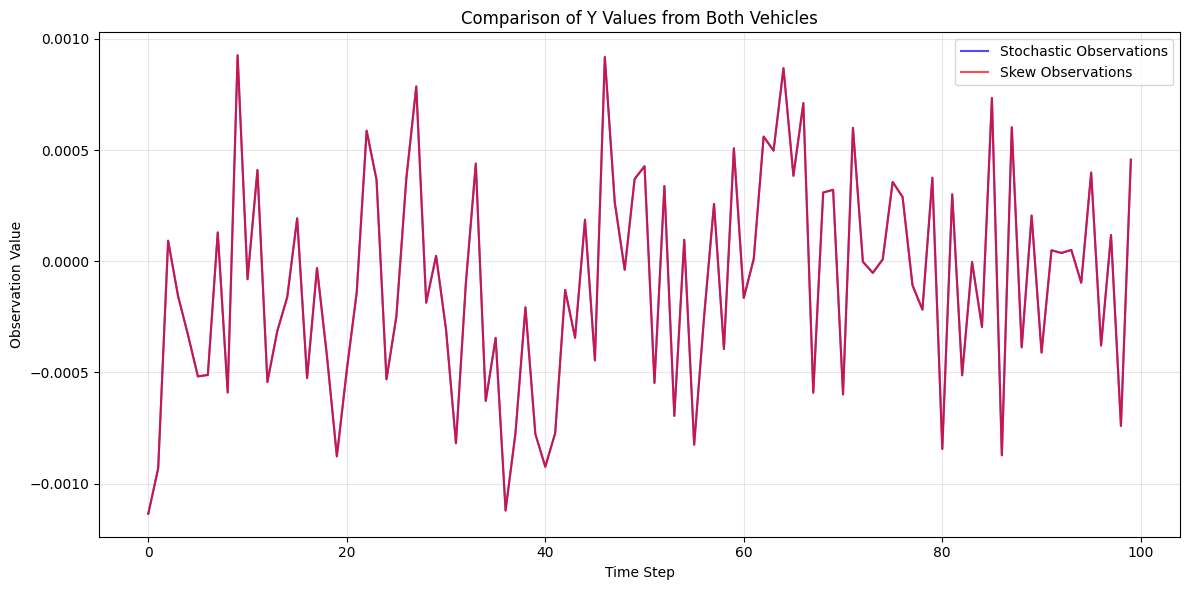

In [75]:
import matplotlib.pyplot as plt

# Generate data for stochastic vehicle
x_stoch, y_stoch = stoch_pf_vehicle.generate_data(jax.random.PRNGKey(0), 100, 100, X_BAR)
x_first_stoch = x_stoch[0]
y_first_stoch = y_stoch[0]

# Create subplots side by side for stochastic
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot x (hidden state)
ax1.plot(x_first_stoch, label='Hidden State (X)', color='blue')
ax1.set_title('Hidden State Evolution - Stochastic')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('State Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot y (observations)
ax2.plot(y_first_stoch, label='Observations (Y)', color='red')
ax2.set_title('Observation Evolution - Stochastic')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Observation Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Generate data for skew vehicle
x_skew, y_skew = skew_pf_vehicle.generate_data(jax.random.PRNGKey(0), 100, 100, X_BAR)
x_first_skew = x_skew[0]
y_first_skew = y_skew[0]

# Create subplots side by side for skew
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot x (hidden state)
ax1.plot(x_first_skew, label='Hidden State (X)', color='blue')
ax1.set_title('Hidden State Evolution - Skew')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('State Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot y (observations)
ax2.plot(y_first_skew, label='Observations (Y)', color='red')
ax2.set_title('Observation Evolution - Skew')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Observation Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final comparison plot - Y values from both vehicles
plt.figure(figsize=(12, 6))
plt.plot(y_first_stoch, label='Stochastic Observations', color='blue', alpha=0.7)
plt.plot(y_first_skew, label='Skew Observations', color='red', alpha=0.7)
plt.title('Comparison of Y Values from Both Vehicles')
plt.xlabel('Time Step')
plt.ylabel('Observation Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
